## The Notebook for Photodissociation Data Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from processing import ProcessData
from constants import ApproachEnum, MeasureEnum, lifetime_outfile, confidence, plot_params, succ_rate_outfile, outplotdir
from pathlib import Path
from scipy.constants import h, c
%matplotlib inline

### Process dissociation data

In [2]:
task = 'run_5'
process = ProcessData(task, copy_files=False, do_2photon=False, process_y_line_sum=False)

In [3]:
process.run(do_int=True, do_liv=True, plot=True, save_plot=True)

In [4]:
df = pd.read_csv(lifetime_outfile(task, MeasureEnum.live, ApproachEnum.bayesian), sep="    ", engine="python")
df

,wl(nm),mean_lt(s),mle_lt(s),CI_low[lt],CI_high[lt],int(W/m2),int_er,label,file
0,265,37.691579,34.2,29.1,45.9,137.316930,10.402870,265 p6 2 230208,2023_02_08_11h_37m_02s_dissociation_measurement
1,260,40.926071,38.1,33.0,48.3,158.228247,12.922014,260 p6 1 230209,2023_02_09_09h_45m_38s_dissociation_measurement
2,275,222.402453,177.9,148.8,293.1,785.604791,61.867497,275 p30 1 230213,2023_02_13_00h_00m_00s_dissociation_measurement
3,270,21.120952,19.2,16.5,25.5,1534.708353,119.451488,270 p60 1 230214,2023_02_14_10h_37m_15s_dissociation_measurement
4,267,12.703810,11.7,9.6,15.3,1612.533378,129.263850,267 p60 1 230215,2023_02_15_11h_00m_56s_dissociation_measurement
5,255,40.855000,36.3,30.6,50.4,169.331740,14.168400,255 p6 1 230216,2023_02_16_11h_21m_18s_dissociation_measurement
6,250,36.368462,31.5,26.4,45.9,183.006829,15.947852,250 p6 1 230221,2023_02_21_10h_39m_46s_dissociation_measurement
7,245,28.123000,25.5,21.6,34.2,170.634663,14.306636,245 p6 1 230222,2023_02_22_11h_29m_14s_dissociation_measurement


### Monte Carlo uncertainty calculation

In [5]:
def samples_file_intensity(measurement):
    return Path().cwd().joinpath(f'samples/samples_intensity/{measurement}_intensity.npy')
def samples_file_lifetime(measurement, meas_type:MeasureEnum):
    return Path().cwd().joinpath(f'samples/samples_lifetime/{measurement}_lifetime_{meas_type.value}.npy')
def samples_array_intensity():
    samples_list = []
    for measurement in process.data.datainfo_json.keys():
        with open(samples_file_intensity(measurement), 'rb') as f:
            samples = np.load(f)
            samples_list.append(samples)
    return np.array(samples_list).T
def samples_array_lifetime(meas_type:MeasureEnum):
    samples_list = []
    for measurement in process.data.datainfo_json.keys():
        with open(samples_file_lifetime(measurement, meas_type), 'rb') as f:
            samples = np.load(f)
            samples_list.append(samples)
    return np.array(samples_list).T

In [6]:
samples_intensity = samples_array_intensity()
print(np.mean(samples_intensity, axis=0))
samples_lifetime = samples_array_lifetime(MeasureEnum.live)
print(np.mean(samples_lifetime, axis=0))

wavelength = df["wl(nm)"].values
intensity = df["int(W/m2)"].values
lifetime = df["mle_lt(s)"].values
conv = h * c / 1e-9 / 1e-4 * 1e18 # nm(1e-9), cm^2(1e-4), cross section(1e-18)
cs = conv / wavelength / lifetime / intensity
d_cs = []
for i, w in enumerate(wavelength):
    _samples = (conv / w / samples_lifetime.T[i] / samples_intensity.T[i])
    d_cs.append([
        cs[i] - np.percentile(_samples, (1-confidence)/2*100),
        np.percentile(_samples, (1+confidence)/2*100) - cs[i]
    ])
d_cs = np.array(d_cs).T

[ 137.31692954  158.22824695  785.60479106 1534.70835278 1612.53337801
  169.33174027  183.00682857  170.63466346]
[ 37.688925  40.922193 222.836508  21.124791  12.682122  40.806678
  36.343875  28.11129 ]


In [7]:
print(cs)
print(d_cs)

[1.5961756  1.26734365 0.05168493 0.24968122 0.39434006 1.26733537
 1.37834798 1.86338763]
[[0.41891313 0.28412868 0.02057735 0.06402979 0.09701506 0.36498101
  0.43908347 0.48662215]
 [0.2918978  0.20755374 0.0105505  0.04287022 0.07512694 0.24178632
  0.27407689 0.33309074]]


### Cross section plot

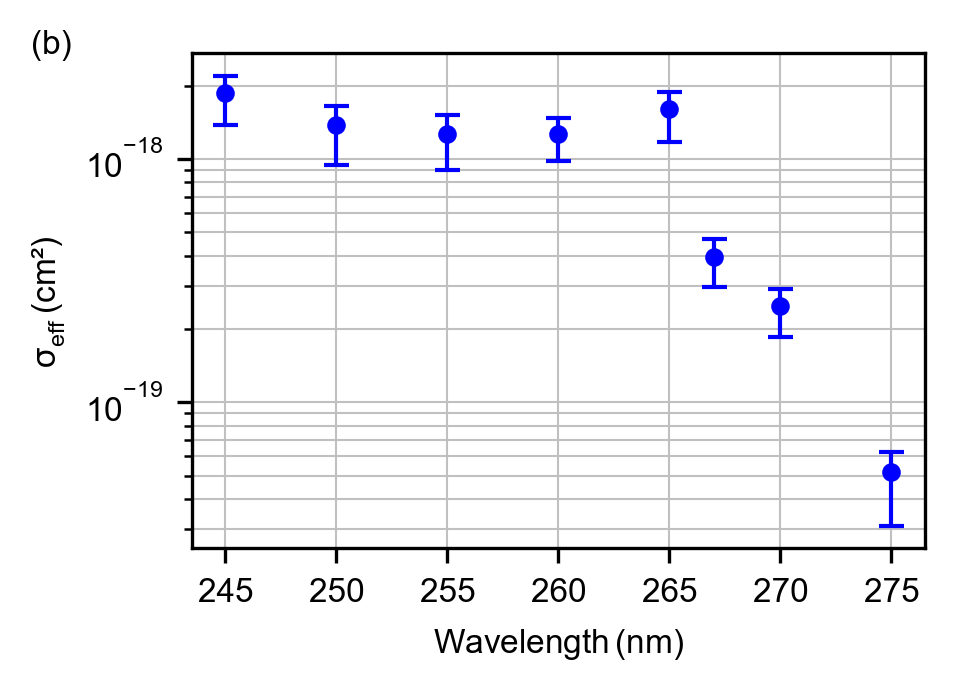

In [8]:
plt.rcParams.update(plot_params)
fig, ax = plt.subplots()
ax.scatter(wavelength, cs*1e-18, marker="o", c="b", s=12, zorder=10)
ax.errorbar(wavelength, cs*1e-18, yerr=d_cs*1e-18, fmt="", ls="none", ecolor="b", elinewidth=1.0, capsize=3.0, capthick=1.0)
ax.set_xlabel(r"$Wavelength \, (nm)$")
ax.set_ylabel(r"$\sigma_{eff} \, (cm²)$")
ax.grid(True, which="both")
ax.set_yscale("log")
ax.text(-0.22, 1.0, "(b)", transform=plt.gca().transAxes)
plt.savefig('spectrum_1photon.eps', format='eps', dpi=300)

### Memorylessness verification based on interval data

In [9]:
df1 = pd.read_csv(lifetime_outfile(task, MeasureEnum.intervals, ApproachEnum.bayesian), sep="    ", engine="python")
df1

,wl(nm),mean_lt(s),mle_lt(s),CI_low[lt],CI_high[lt],int(W/m2),int_er,label,file
0,265,36.156340,32.4,27.0,45.0,137.301697,10.391256,265 p6 2 230208,2023_02_08_11h_37m_02s_dissociation_measurement
1,260,41.717292,39.3,33.9,49.2,158.218669,12.902697,260 p6 1 230209,2023_02_09_09h_45m_38s_dissociation_measurement
2,275,218.898348,178.8,150.0,285.6,785.954339,61.867256,275 p30 1 230213,2023_02_13_00h_00m_00s_dissociation_measurement
3,270,22.655187,20.1,16.8,28.2,1535.404770,119.527548,270 p60 1 230214,2023_02_14_10h_37m_15s_dissociation_measurement
4,267,9.186243,8.1,6.6,11.4,1613.699016,129.089291,267 p60 1 230215,2023_02_15_11h_00m_56s_dissociation_measurement
5,255,40.059318,35.7,29.7,49.8,169.386446,14.207880,255 p6 1 230216,2023_02_16_11h_21m_18s_dissociation_measurement
6,250,37.091237,33.3,27.6,46.2,183.025351,15.949880,250 p6 1 230221,2023_02_21_10h_39m_46s_dissociation_measurement
7,245,28.889288,26.4,22.2,35.4,170.710682,14.355698,245 p6 1 230222,2023_02_22_11h_29m_14s_dissociation_measurement


In [10]:
df2 = pd.read_csv(succ_rate_outfile(task), sep="    ", engine="python")
df2

,wl(nm),1,5,10,30,60,120,file
0,265,0.136364,0.105263,0.307692,0.333333,1.000000,1.000000,2023_02_08_11h_37m_02s_dissociation_measurement
1,260,0.050000,0.096774,0.242424,0.333333,0.923077,1.000000,2023_02_09_09h_45m_38s_dissociation_measurement
2,275,0.000000,0.083333,0.105263,0.166667,0.111111,0.428571,2023_02_13_00h_00m_00s_dissociation_measurement
3,270,0.062500,0.250000,0.357143,0.666667,1.000000,1.000000,2023_02_14_10h_37m_15s_dissociation_measurement
4,267,0.100000,0.357143,0.800000,1.000000,1.000000,1.000000,2023_02_15_11h_00m_56s_dissociation_measurement
5,255,0.000000,0.071429,0.111111,0.600000,1.000000,1.000000,2023_02_16_11h_21m_18s_dissociation_measurement
6,250,0.000000,0.117647,0.300000,0.444444,1.000000,1.000000,2023_02_21_10h_39m_46s_dissociation_measurement
7,245,0.083333,0.263158,0.444444,0.800000,0.750000,0.833333,2023_02_22_11h_29m_14s_dissociation_measurement


Plotting for 265 nm


<Figure size 990x660 with 0 Axes>

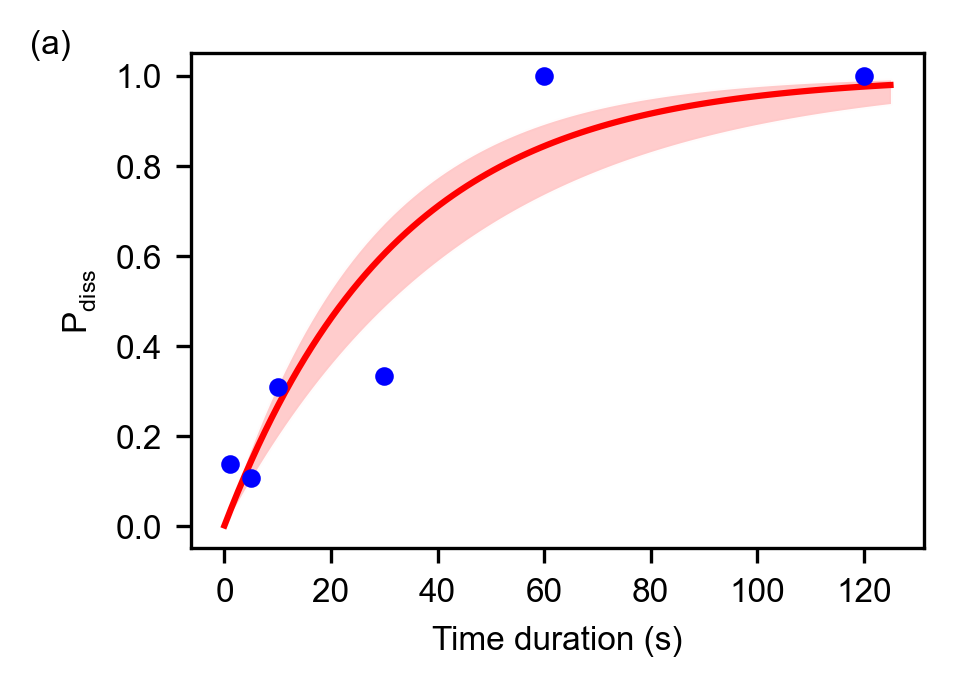

Plotting for 260 nm


<Figure size 990x660 with 0 Axes>

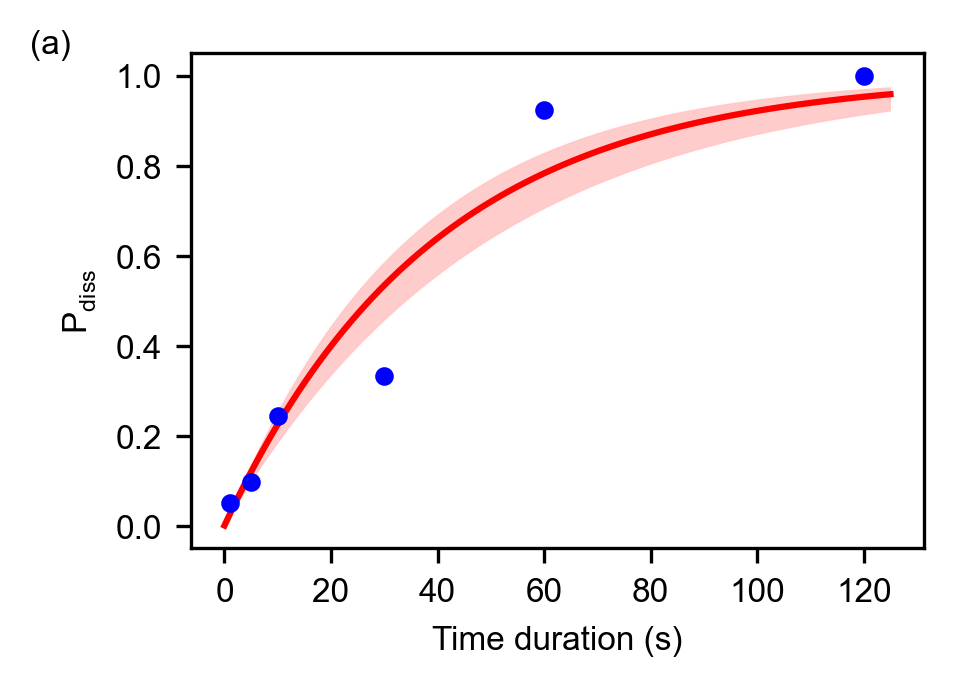

Plotting for 275 nm


<Figure size 990x660 with 0 Axes>

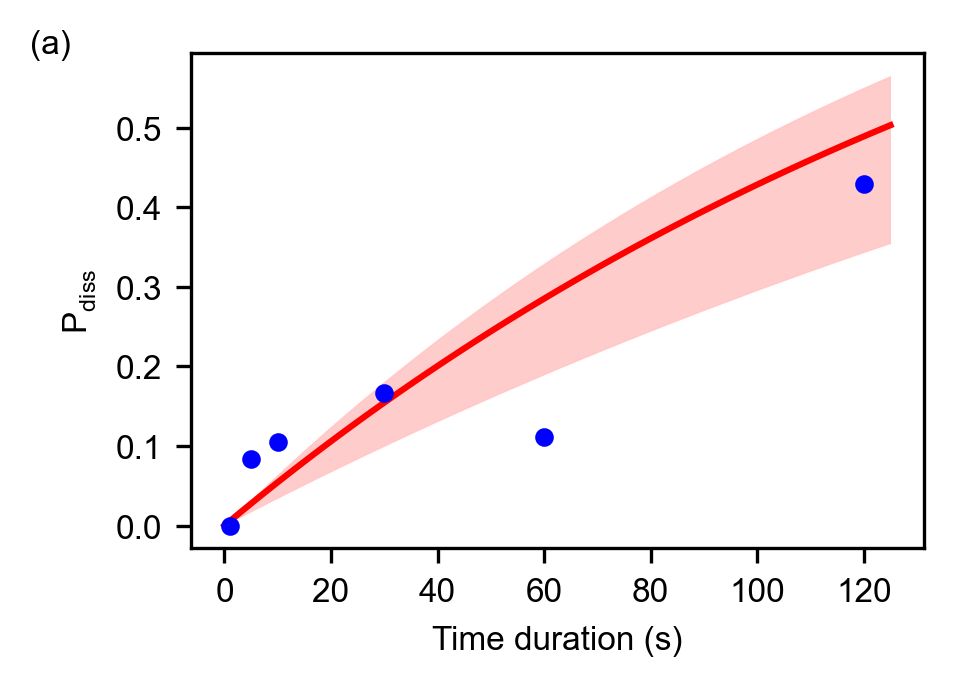

Plotting for 270 nm


<Figure size 990x660 with 0 Axes>

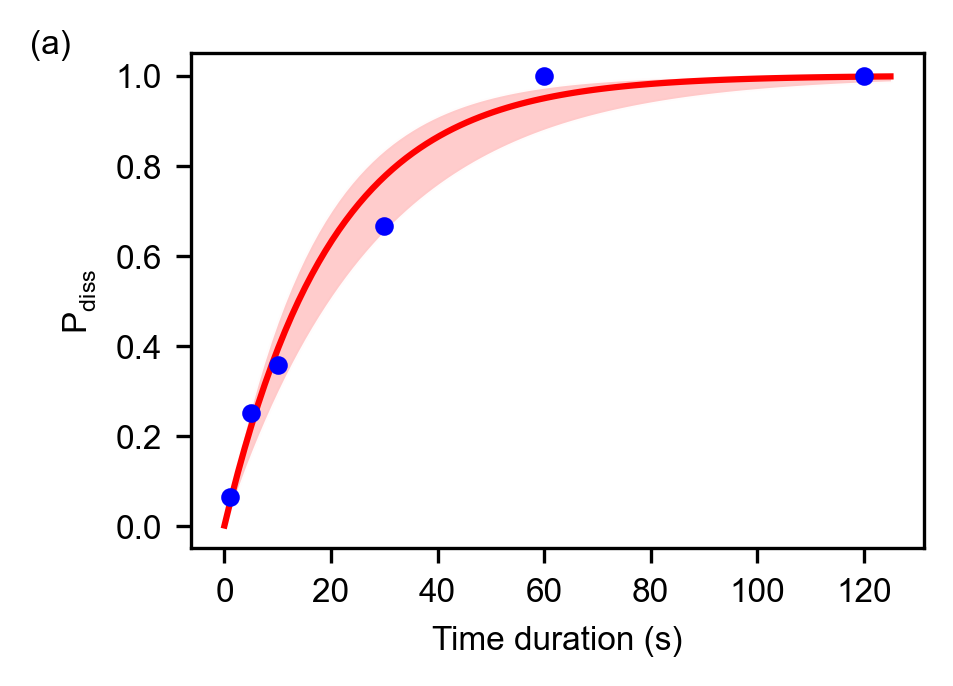

Plotting for 267 nm


<Figure size 990x660 with 0 Axes>

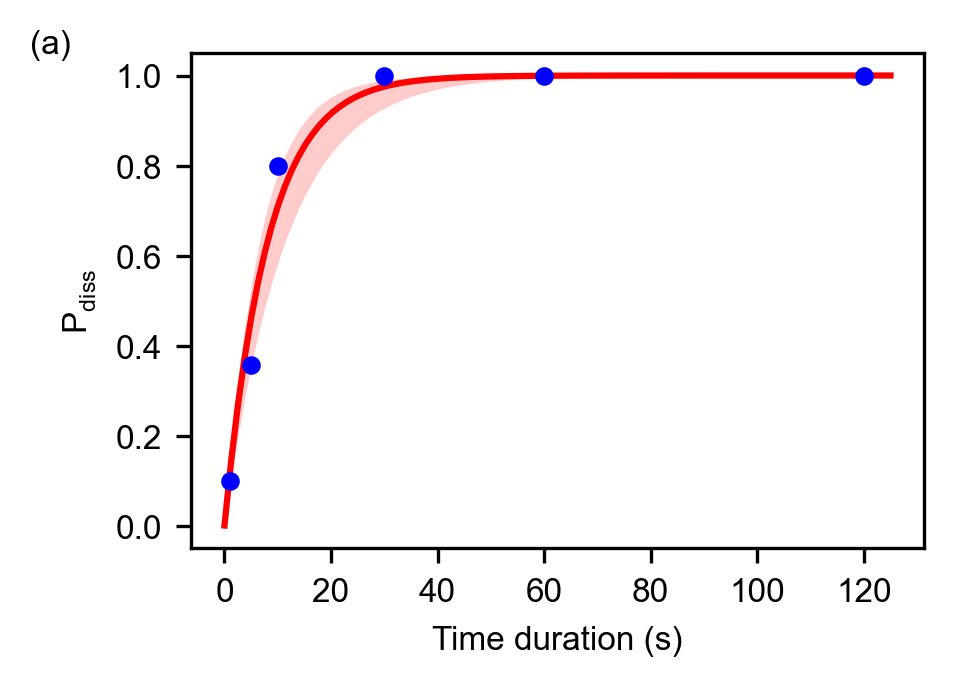

Plotting for 255 nm


<Figure size 990x660 with 0 Axes>

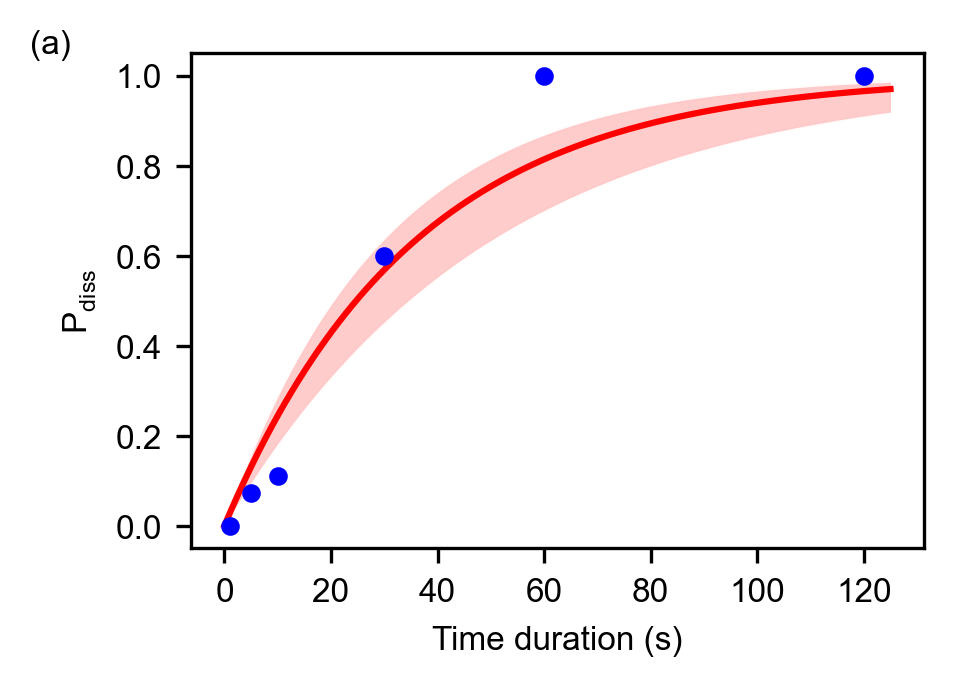

Plotting for 250 nm


<Figure size 990x660 with 0 Axes>

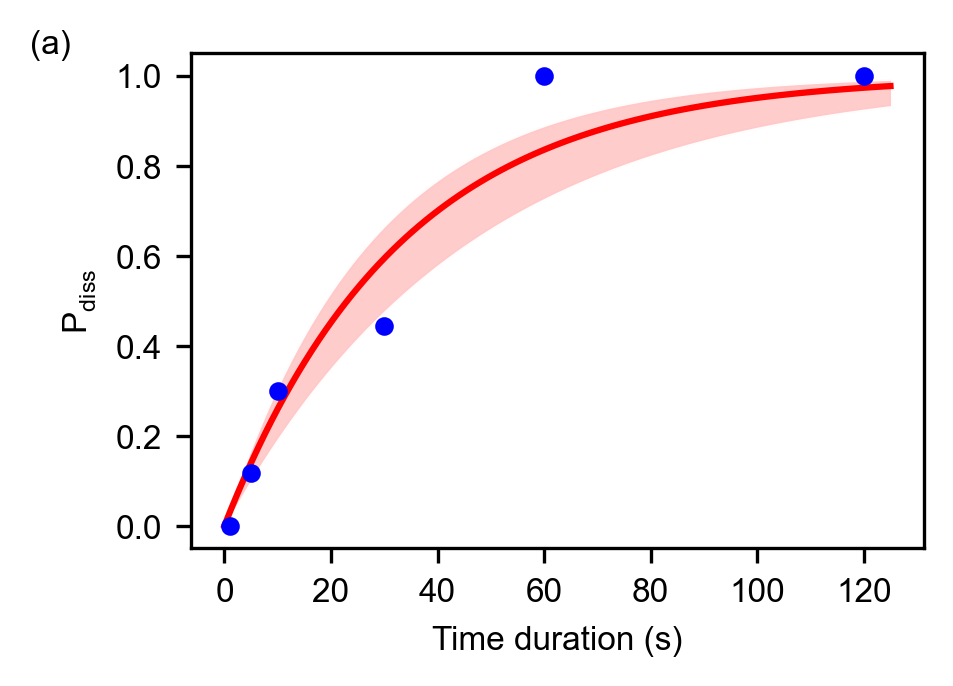

Plotting for 245 nm


<Figure size 990x660 with 0 Axes>

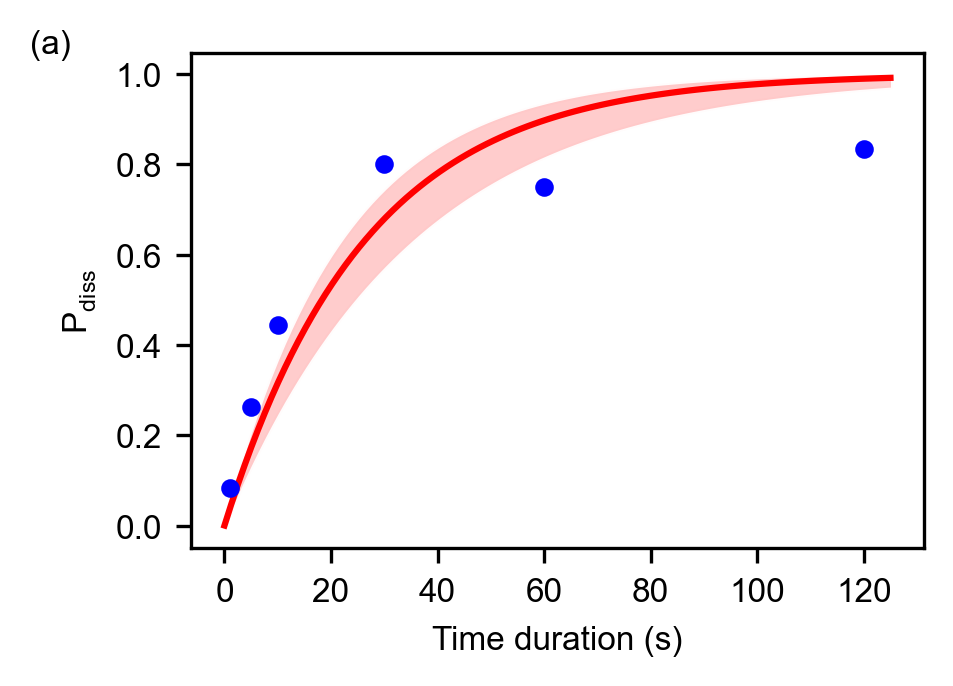

In [11]:
wavelength = df1["wl(nm)"].values
intensity = df1["int(W/m2)"].values
lifetime = df1["mle_lt(s)"].values
lt_high = df1["CI_high[lt]"].values
lt_low = df1["CI_low[lt]"].values
intervals = [1, 5, 10, 30, 60, 120]
x = np.linspace(0, 125, 100)
plt.rcParams.update(plot_params)
for i in range(len(wavelength)):
    plt.clf()
    fig, ax = plt.subplots()
    succ_rates = [df2[str(intv)][i] for intv in intervals]
    ax.scatter(intervals, succ_rates, marker="o", c="b", s=12, zorder=10)
    y = 1 - np.exp(-x/lifetime[i])
    y_low = 1 - np.exp(-x/lt_high[i])
    y_high = 1 - np.exp(-x/lt_low[i])
    ax.plot(x, y, '-', c='r')
    ax.fill_between(x, y_low, y_high, facecolor=(1,0,0,.2), edgecolor=(1,0,0,.01))
    ax.set_xlabel(r"Time duration (s)")
    ax.set_ylabel(r"$P_{diss}$")
    # ax.set_title(f"Dissociation probability at {wavelength[i]} nm")
    ax.text(-0.22, 1.0, "(a)", transform=plt.gca().transAxes)
    ax.set_rasterized(True)
    plt.savefig(outplotdir(task).joinpath(f'dissociation_probability_vs_time_duration_{wavelength[i]}_nm.pdf'), format='pdf', dpi=300)
    print(f"Plotting for {wavelength[i]} nm")
    plt.show()


### Compare between real-time and interval based spectra

In [12]:
samples_intensity = samples_array_intensity() 
print(np.mean(samples_intensity, axis=0))
samples_lifetime_int = samples_array_lifetime(MeasureEnum.intervals)
print(np.mean(samples_lifetime_int, axis=0))

wavelength = df1["wl(nm)"].values
intensity = df1["int(W/m2)"].values
lifetime = df1["mle_lt(s)"].values
conv = h * c / 1e-9 / 1e-4 * 1e18 # nm(1e-9), cm^2(1e-4), cross section(1e-18)
cs_int = conv / wavelength / lifetime / intensity
d_cs_int = []
for i, w in enumerate(wavelength):
    _samples = (conv / w / samples_lifetime_int.T[i] / samples_intensity.T[i])
    d_cs_int.append([
        cs_int[i] - np.percentile(_samples, (1-confidence)/2*100),
        np.percentile(_samples, (1+confidence)/2*100) - cs_int[i]
    ])
d_cs_int = np.array(d_cs_int).T

[ 137.31692954  158.22824695  785.60479106 1534.70835278 1612.53337801
  169.33174027  183.00682857  170.63466346]
[ 36.149658  41.764233 218.528211  22.656966   9.188712  40.11495
  37.112667  28.90041 ]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


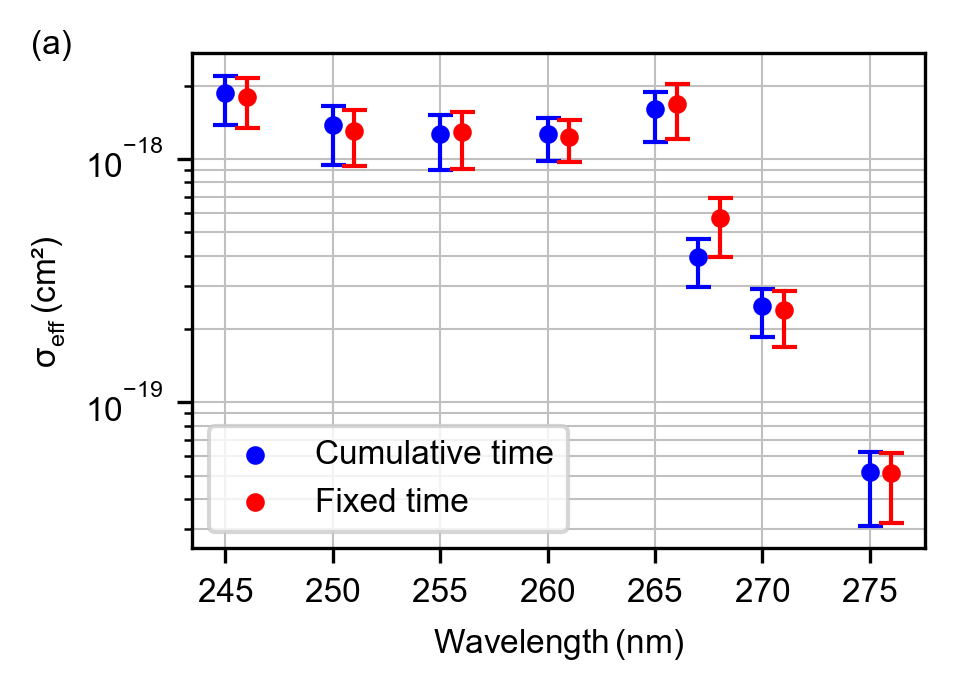

In [13]:
plt.rcParams.update(plot_params)
fig, ax = plt.subplots()
ax.scatter(wavelength, cs*1e-18, marker="o", c="b", s=12, zorder=10, label="Cumulative time")
ax.errorbar(wavelength, cs*1e-18, yerr=d_cs*1e-18, fmt="", ls="none", ecolor="b", elinewidth=1.0, capsize=3.0, capthick=1.0)
ax.scatter(wavelength+1, cs_int*1e-18, marker="o", c="r", s=12, zorder=20, label="Fixed time")
ax.errorbar(wavelength+1, cs_int*1e-18, yerr=d_cs_int*1e-18, fmt="", ls="none", ecolor="r", elinewidth=1.0, capsize=3.0, capthick=1.0, zorder=20)
ax.set_xlabel(r"$Wavelength \, (nm)$")
ax.set_ylabel(r"$\sigma_{eff} \, (cm²)$")
ax.grid(True, which="both")
ax.set_yscale("log")
ax.legend()
ax.text(-0.22, 1.0, "(a)", transform=plt.gca().transAxes)
plt.savefig('spectrum_1photon_compare.eps', format='eps', dpi=300)